In [ ]:
!python -m pip install fastai

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import sys
sys.path.append('..')
from chessvision.aruco import *
from chessvision.label import *
from chessvision.game import *
from chessvision.trainer import *

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

In [7]:
train_games = [
#     Game("Adams", 0),
    Game("Adams", 1, game_dir="../games"),
    Game("Adams", 2, game_dir="../games"),
    Game("Adams", 3, game_dir="../games"),
]

test_games = [
    Game("Bird", 2, game_dir="../games")
]

In [8]:
len(test_games[0])

93

In [9]:
train_dir = save_games(train_games, label_fn=label, labels=PIECE_LABELS)
test_dir = save_games(test_games, label_fn=label, labels=PIECE_LABELS)
train_dir, test_dir, os.path.basename(train_dir)

('/tmp/chess-vision-dgwyimca',
 '/tmp/chess-vision-ewb2yut7',
 'chess-vision-dgwyimca')

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

data_transform = transforms.Compose([
    transforms.Resize(56),
#     transforms.Grayscale(),
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                              std=[0.229, 0.224, 0.225])
])


chess_datasets = {'train': ChessFolder(root=train_dir, transform=data_transform),
                  'val'  : ChessFolder(root=test_dir, transform=data_transform)}

dataloaders = {'train': DataLoader(chess_datasets['train'], shuffle=True, batch_size=4, num_workers=4),
               'val': DataLoader(chess_datasets['val'], batch_size=50, num_workers=4)}

dataset_sizes = {x: len(chess_datasets[x]) for x in ['train', 'val']}
labels_dict = {hash(label): label for label in PIECE_LABELS}

cpu


In [19]:
dataset_sizes

{'train': 252, 'val': 93}

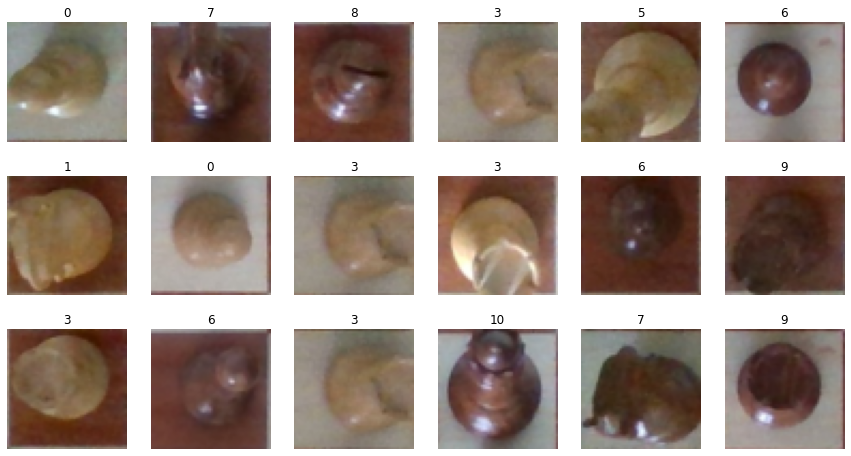

In [20]:
figure = plt.figure(figsize=(15, 8))
cols, rows = 6, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(dataset_sizes['val'], size=(1,)).item()
    img, label = chess_datasets['val'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
plt.show()

In [2]:
from fastai.vision.all import *

In [10]:
dls = ImageDataLoaders.from_folder("/tmp", train=os.path.basename(train_dir), valid=os.path.basename(test_dir))

SuggestedLRs(valley=0.0012022644514217973)

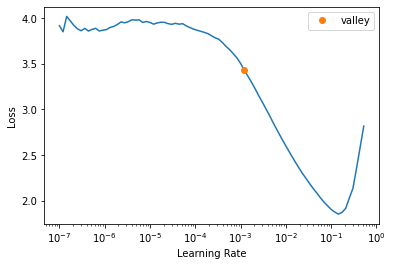

In [29]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.lr_find()

In [30]:
learn.fine_tune(15, base_lr=0.0015)

epoch,train_loss,valid_loss,accuracy,time
0,3.971630,4.104917,0.043011,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.266009,3.096030,0.096774,00:02
1,3.004981,2.518683,0.182796,00:01
2,2.646254,2.123216,0.311828,00:02
3,2.312443,1.805462,0.408602,00:02
4,1.970461,1.574902,0.505376,00:02
5,1.676359,1.418943,0.548387,00:02
6,1.427076,1.312275,0.548387,00:02
7,1.241604,1.227023,0.623656,00:02
8,1.089791,1.185789,0.645161,00:02
9,0.966883,1.163605,0.645161,00:02


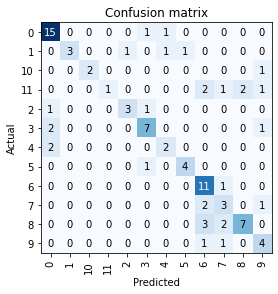

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

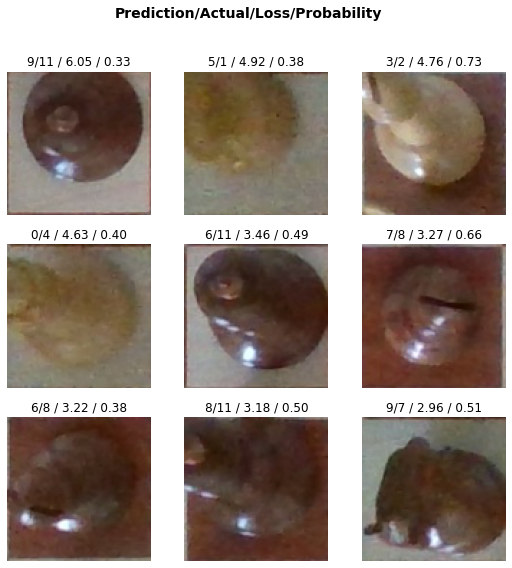

In [33]:
interp.plot_top_losses(10)